In [1]:
import os
os.chdir("../..")
import dotenv


dotenv.load_dotenv(override=True)

print(os.getcwd(), os.getenv("HF_HOME"))

import json
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from hashlib import sha256
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

/data1/xhuan192/codes/med-sipf cache/


/data1/xhuan192/misc/miniconda3/envs/xiaoke-med_sipf-1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'/data1/xhuan192/codes/med-sipf'

In [3]:
# aka., "UCSC-VLAA/m23k-tokenized"
path = "mmqm/m196k-dedup-decon-filter_easy-r1-filter_wrong-decon_eval"
split = "train"
dataset = datasets.load_dataset(path, split=split)
from collections import Counter
source_list = dataset["source"]
source_counter = Counter(source_list)
source_counter

Counter({'openlifescienceai/medmcqa': 21628,
         'GBaker/MedQA-USMLE-4-options': 1628,
         'openlifescienceai/headqa': 209,
         'qiaojin/PubMedQA:pqa_labeled': 28})

In [4]:
dataset

Dataset({
    features: ['answer_idx', 'source', 'metadata', 'prompt', 'answer_letter', 'answer_string', 'qwen_7b-extracted_answer_string', 'qwen_7b-model_answer_string', 'qwen_7b-correct', 'qwen_32b-extracted_answer_string', 'qwen_32b-model_answer_string', 'qwen_32b-correct', 'reasoning', 'distilled_answer_string', 'r1-extracted_answer_string', 'r1-model_answer_string', 'r1-correct'],
    num_rows: 23493
})

In [5]:
dataset[0]["reasoning"], dataset[0]["distilled_answer_string"]

('Okay, let me try to work through this question. Let\'s start by reading it carefully.\n\nSo, the scenario is a 3-week-old infant with fussiness, regurgitating all feeds, and yellow vomit for the past 4 days. The baby was born without complications and no prior medical issues. On physical exam, the abdomen is minimally distended but otherwise normal. The question is asking which embryologic error could account for this presentation. The options are A through D: hypertrophic pylorus, failure of lateral body folds to ventrally fuse, abnormal ventral pancreatic bud migration, or complete failure of proximal duodenum to recanalize.\n\nFirst, the symptoms. Yellow vomit—bilious vomiting, right? So that\'s a sign of possible intestinal obstruction distal to the ampulla of Vater, where bile is introduced into the intestine. So in a newborn, bilious vomiting makes me think of intestinal obstruction.\n\nThe baby is 3 weeks old. The fact that this started around 3 weeks makes me think about comm

In [6]:
from transformers import AutoTokenizer
from functools import partial

tokenizer_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def get_num_tokens(x, tokenizer):
    reasoning = x["reasoning"]
    answer = x["distilled_answer_string"]
    
    num_reason_tokens = len(tokenizer(reasoning)["input_ids"])
    num_answer_tokens = len(tokenizer(answer)["input_ids"])
    return {
        "num_reason_tokens": num_reason_tokens,
        "num_answer_tokens": num_answer_tokens,
    }

mapped_dataset = dataset.map(partial(get_num_tokens, tokenizer=tokenizer))

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
num_reason_tokens = pd.Series(mapped_dataset["num_reason_tokens"])
print(f"Number of tokens per sample statistics:\n{num_reason_tokens.describe()}")

num_answer_tokens = pd.Series(mapped_dataset["num_answer_tokens"])
print(f"Number of tokens per sample statistics:\n{num_answer_tokens.describe()}")

Number of tokens per sample statistics:
count    23493.000000
mean      1382.610565
std       1066.201339
min        193.000000
25%        625.000000
50%        985.000000
75%       1791.000000
max       7461.000000
dtype: float64
Number of tokens per sample statistics:
count    23493.000000
mean       194.040906
std         83.854438
min         22.000000
25%        132.000000
50%        181.000000
75%        241.000000
max        698.000000
dtype: float64


Text(0, 0.5, 'Number of samples')

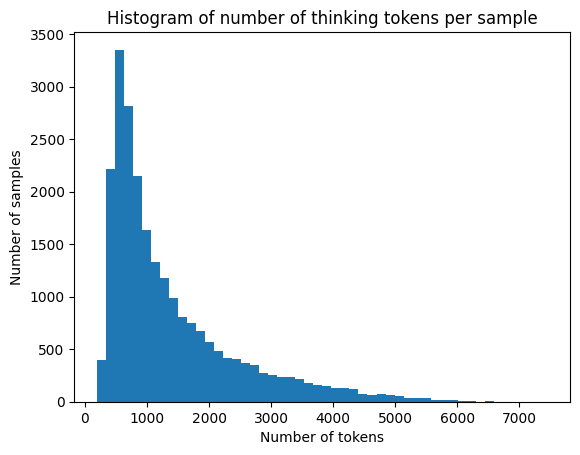

In [8]:
# Plot hist
plt.cla()
plt.hist(num_reason_tokens, bins=50)
plt.title("Histogram of number of thinking tokens per sample")
plt.xlabel("Number of tokens")
plt.ylabel("Number of samples")

Text(0, 0.5, 'Number of samples')

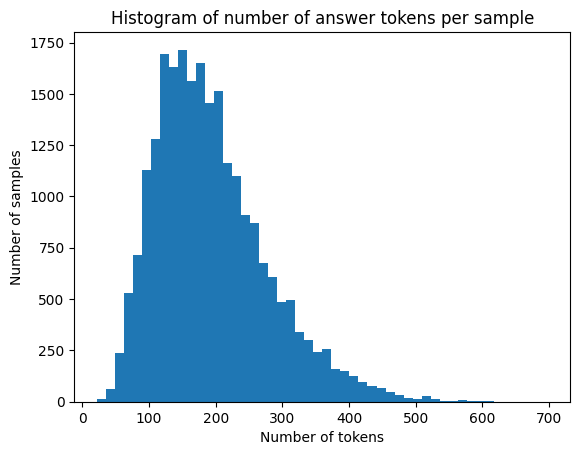

In [9]:
# Plot hist
plt.cla()
plt.hist(num_answer_tokens, bins=50)
plt.title("Histogram of number of answer tokens per sample")
plt.xlabel("Number of tokens")
plt.ylabel("Number of samples")

In [10]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("simplescaling/s1.1-32B")
ds = load_dataset("simplescaling/s1K-1.1")

def addlen(x):
    x['deepseek_len'] = len(tokenizer(x['deepseek_thinking_trajectory'])['input_ids'])
    return x

ds = ds['train'].map(addlen)

In [11]:
num_tokens_s1 = ds['deepseek_len']  # Replace with actual data
num_tokens_s1 = pd.Series(num_tokens_s1)

num_tokens_m1 = pd.Series(num_reason_tokens + num_answer_tokens)

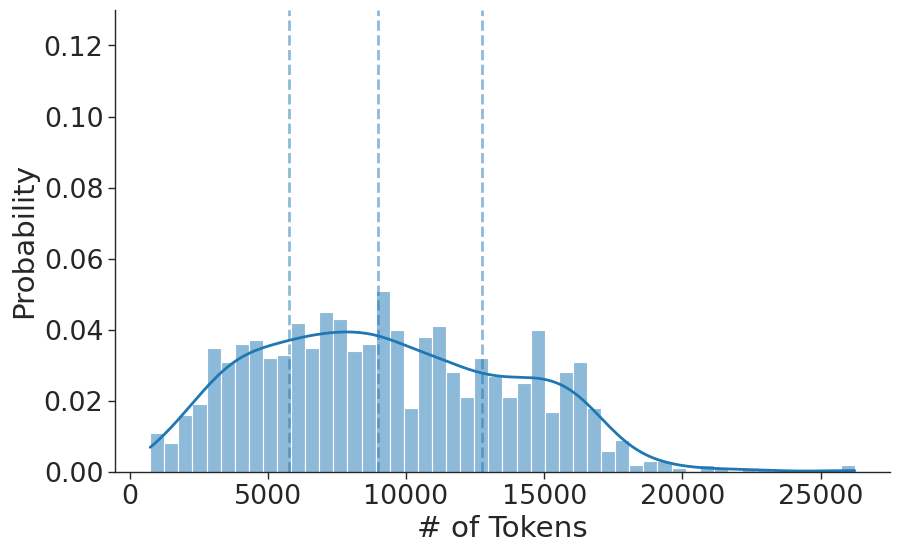

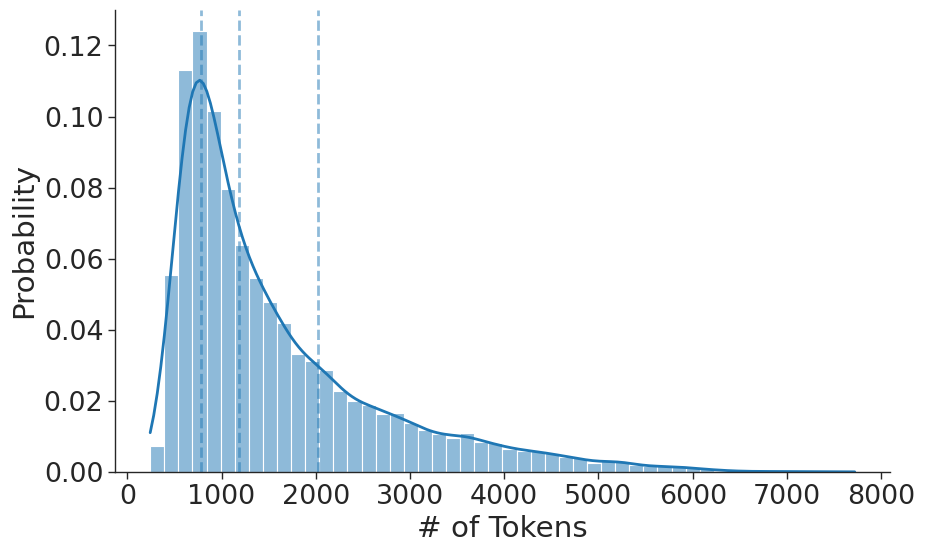

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


plt.rcParams.update({
    'font.family': 'serif',
})

# sns.set_theme()
# Set the style of the visualization
# sns.set_style("white")
sns.set_style("ticks")

# Set the context to "paper" to make the plot suitable for a research paper
sns.set_context("paper", font_scale=2.2, rc={"lines.linewidth": 2})

# Customize the color palette
# sns.set_palette("pastel")


colors = sns.color_palette("pastel", 4)

num_tokens_s1.name = "# of Tokens"
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(num_tokens_s1, bins=50, label='s1', kde=True, ax=ax, stat="probability")
sns.despine()
ax.set_ylim(0, 0.13)

quantiles = ['25%','50%', '75%']
desc = num_tokens_s1.describe()
for i in range(len(quantiles)):
    ax.axvline(desc[quantiles[i]], ls='--', alpha=0.5)

display(fig)
Path("misc").mkdir(exist_ok=True)
fig.savefig("misc/hist_token_s1.pdf", dpi=300, bbox_inches='tight')
fig.clear()




num_tokens_m1.name = "# of Tokens"
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(num_tokens_m1, bins=50,  label='m1', kde=True, ax=ax, stat="probability")
sns.despine()
ax.set_ylim(0, 0.13)

quantiles = ['25%','50%', '75%']
desc = num_tokens_m1.describe()
for i in range(len(quantiles)):
    ax.axvline(desc[quantiles[i]], ls='--', alpha=0.5)

display(fig)
Path("misc").mkdir(exist_ok=True)
fig.savefig("misc/hist_token_m1.pdf", dpi=300, bbox_inches='tight')
fig.clear()